# Treinar embeddings

Neste notebook, vamos implementar e treinar **embeddings de palavras** do zero, consolidando os conceitos fundamentais por trás de representações vetoriais distribuídas usadas em modelos de linguagem.

O foco aqui é entender **como os embeddings são aprendidos durante o treinamento**, em vez de apenas utilizá-los prontos, conectando teoria e prática de forma explícita.

## Objetivos

Ao final deste notebook, você será capaz de:

- Compreender o papel dos **embeddings treináveis** em modelos de linguagem
- Implementar uma camada de embeddings do zero
- Treinar embeddings a partir de dados textuais
- Analisar como palavras semanticamente relacionadas emergem próximas no espaço vetorial
- Conectar o treinamento de embeddings com arquiteturas vistas anteriormente (ex.: CBoW)

## Contexto

Este notebook dá continuidade aos conceitos apresentados anteriormente, especialmente:

- Tokenização e vocabulário
- Representação vetorial de palavras
- Modelos baseados em contexto, como **CBoW**

Aqui, avançamos um passo além, treinando explicitamente os vetores de palavras como **parâmetros aprendíveis** de um modelo neural.

## O que será implementado

- Preparação dos dados de treino
- Inicialização da matriz de embeddings
- Forward e backward pass para aprendizado dos vetores
- Loop de treinamento
- Inspeção e interpretação dos embeddings aprendidos

In [1]:
from __future__ import annotations

import os
import shutil
from pathlib import Path
from typing import Iterable

from collections import Counter
import json

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from build_llm.wikipedia import baixar_wikipedia_e_salvar_com_pacote
from build_llm.pipeline import pipeline_dataset_e_embeddings

## Funções úteis

In [2]:
def caminho_relativo(p: str | Path, start: str | Path | None = None) -> Path:
    """
    Converte um caminho (possivelmente absoluto) para relativo ao diretório `start`
    (por padrão, o diretório atual).

    Se o caminho estiver em outro drive no Windows, mantém o original.

    Parâmetros
    ----------
    p : str | Path
        Caminho de entrada.
    start : str | Path | None
        Diretório base para o relativo. Se None, usa Path.cwd().

    Retorno
    -------
    Path
        Caminho relativo (quando possível).
    """
    p = Path(p)
    base = Path.cwd() if start is None else Path(start)

    try:
        return Path(os.path.relpath(p, start=base))
    except ValueError:
        # Ex.: caminhos em drives diferentes no Windows
        return p


In [3]:
def limpar_conteudo_de_pastas_exceto_gitkeep(
    pastas: Iterable[str | Path],
    *,
    dry_run: bool = True,
    criar_se_nao_existir: bool = False,
) -> None:
    """
    Remove TODOS os arquivos e subpastas dentro das pastas informadas,
    preservando apenas arquivos chamados '.gitkeep' (em qualquer subnível),
    e preservando as pastas necessárias para manter esses '.gitkeep'.

    Parâmetros:
    ----------
    pastas : Iterable[str | Path]
        Lista/iterável de caminhos de pastas a serem limpas.
    dry_run : bool, default = True
        Se True, não apaga nada; apenas mostra o que seria removido.
        Se False, realiza a remoção de fato.
    criar_se_nao_existir : bool, default = False
        Se True, cria a pasta caso não exista. Se False, apenas avisa e pula.

    Retorno:
    -------
    None

    Exceções:
    --------
    Levanta NotADirectoryError se o caminho existir e não for diretório.
    Pode levantar PermissionError / OSError em problemas de permissão/IO.
    """
    for p in pastas:
        raiz = Path(p).expanduser().resolve()

        if not raiz.exists():
            if criar_se_nao_existir:
                if dry_run:
                    print(f"[DRY-RUN] Criaria a pasta: {raiz}")
                else:
                    raiz.mkdir(parents=True, exist_ok=True)
                    print(f"[OK] Pasta criada: {raiz}")
            else:
                print(f"[PULAR] Pasta não existe: {raiz}")
            continue

        if not raiz.is_dir():
            raise NotADirectoryError(f"O caminho existe, mas não é uma pasta: {raiz}")

        # 1) Descobrir todos os .gitkeep (em qualquer nível)
        gitkeeps = {g.resolve() for g in raiz.rglob(".gitkeep") if g.is_file()}

        # 2) Montar conjunto de pastas que precisam existir para manter os .gitkeep
        pastas_a_manter: set[Path] = set()
        for g in gitkeeps:
            try:
                # inclui todos os pais desde a raiz até o diretório do .gitkeep
                rel = g.parent.relative_to(raiz)
                cur = raiz
                pastas_a_manter.add(cur)
                for part in rel.parts:
                    cur = cur / part
                    pastas_a_manter.add(cur.resolve())
            except ValueError:
                # caso muito raro: .gitkeep fora da raiz (symlink etc.)
                pass

        # 3) Remover tudo que não seja .gitkeep; depois remover pastas vazias não necessárias
        # Primeiro apaga arquivos (exceto .gitkeep)
        for item in raiz.rglob("*"):
            if item.is_dir():
                continue

            if item.resolve() in gitkeeps:
                continue

            if dry_run:
                print(f"[DRY-RUN] Removeria arquivo: {item}")
            else:
                try:
                    item.unlink()
                    print(f"[REMOVIDO] {item}")
                except Exception as e:
                    print(f"[ERRO] Falha ao remover arquivo {item}: {e}")
                    raise

        # Agora remove diretórios vazios, de baixo para cima, exceto os que devem ser mantidos
        # (inclui a própria raiz em pastas_a_manter, então ela nunca é removida)
        dirs = sorted([d for d in raiz.rglob("*") if d.is_dir()], key=lambda x: len(x.parts), reverse=True)
        for d in dirs:
            d_res = d.resolve()
            if d_res in pastas_a_manter:
                continue

            # se estiver vazio, pode remover
            try:
                if not any(d.iterdir()):
                    if dry_run:
                        print(f"[DRY-RUN] Removeria pasta vazia: {d}")
                    else:
                        d.rmdir()
                        print(f"[REMOVIDO] {d}")
            except Exception as e:
                print(f"[ERRO] Falha ao avaliar/remover pasta {d}: {e}")
                raise


limpar_conteudo_de_pastas_exceto_gitkeep(
    ["../../data", "../../models"],
    dry_run=False,  # <-- troque para False para apagar de verdade
    criar_se_nao_existir=False,
)


## Baixando o conjunto de treinamento: Wiki do Machado de assis

In [4]:
caminho = baixar_wikipedia_e_salvar_com_pacote(
    assunto="Machado de Assis",
    pasta_destino="../../data/dados_wiki",
    idioma="pt",
)
caminho_rel = Path(os.path.relpath(caminho, start=Path.cwd()))
print(f"Arquivo salvo! {caminho_rel=}")

Arquivo salvo! caminho_rel=WindowsPath('../../data/dados_wiki/Machado_de_Assis.txt')


## Pipeline de treinamento dos embeddings

In [5]:
resultado = pipeline_dataset_e_embeddings(
    caminho_texto="../../data/dados_wiki/Machado_de_Assis.txt",
    nome_base="machado_assis_wiki",

    # dataset GPT
    batch_size_gpt=8,
    max_length=128,
    stride=128,

    # treino embeddings (CBOW)
    treinar_embeddings=True,
    embedding_dim=256,
    cbow_janela=2,
    cbow_batch_size=256,
    cbow_epocas=50,
    cbow_lr=0.05,
)

print("Pasta data:", caminho_relativo(resultado["pasta_data"]))
print("Vocab compacto:", resultado["vocab_size_compacto"])
print("Num batches GPT (aprox):", len(resultado["dataloader_gpt"]))

if "pasta_models" in resultado:
    print("Pasta models:", caminho_relativo(resultado["pasta_models"]))
    print("Pesos token embedding:", caminho_relativo(resultado["caminho_pesos_token_embedding"]))



Treinando CBOW no dispositivo: cpu
[cpu] Época 001/50 | loss médio: 8.0139
[cpu] Época 010/50 | loss médio: 6.5349
[cpu] Época 020/50 | loss médio: 5.7974
[cpu] Época 030/50 | loss médio: 5.3527
[cpu] Época 040/50 | loss médio: 5.0395
[cpu] Época 050/50 | loss médio: 4.8008
Pasta data: ..\..\data\gpt_data_machado_assis_wiki
Vocab compacto: 3232
Num batches GPT (aprox): 40
Pasta models: ..\..\models\cbow_embeddings_machado_assis_wiki
Pesos token embedding: ..\..\models\cbow_embeddings_machado_assis_wiki\token_embedding_weight.pt


## Exibição dos resultados

In [6]:
def _carregar_json(path: Path) -> dict:
    """
    Lê um JSON e retorna dict.

    Parâmetros
    ----------
    path : Path
        Caminho do arquivo JSON.

    Retorno
    -------
    dict
        Conteúdo do JSON.
    """
    return json.loads(path.read_text(encoding="utf-8"))


def _inferir_compacto_para_raw(remap_dict: dict, vocab_size_compacto: int) -> list[int] | None:
    """
    Tenta inferir um mapeamento compacto->raw a partir do dict de remapeamento.

    Estratégias:
    1) procurar uma LISTA de inteiros com len == vocab_size_compacto (provável compacto->raw)
    2) procurar um DICT raw->compacto e inverter

    Retorno
    -------
    list[int] | None
        Lista compact_id -> raw_id, ou None se não der para inferir.
    """
    # 1) lista direta compacto->raw
    for v in remap_dict.values():
        if isinstance(v, list) and len(v) == vocab_size_compacto:
            if len(v) == 0:
                continue
            if all(isinstance(x, int) for x in v[: min(10, len(v))]):
                return v

    # 2) dict raw->compacto (inverter)
    for v in remap_dict.values():
        if isinstance(v, dict) and len(v) > 0:
            # chaves podem ser str (raw_id como string) e valores int (compact_id)
            vals = list(v.values())
            if all(isinstance(x, int) for x in vals[: min(10, len(vals))]):
                compacto_para_raw = [None] * vocab_size_compacto  # type: ignore[list-item]
                ok = True
                for raw_k, compact_id in v.items():
                    try:
                        raw_id = int(raw_k)
                    except Exception:
                        ok = False
                        break
                    if not (0 <= compact_id < vocab_size_compacto):
                        ok = False
                        break
                    compacto_para_raw[compact_id] = raw_id
                if ok and all(x is not None for x in compacto_para_raw):
                    return [int(x) for x in compacto_para_raw]

    return None


def _decoder_raw_ids(raw_ids: list[int], encoding_name: str = "gpt2") -> list[str]:
    """
    Decodifica IDs "raw" (GPT-2 BPE) para strings, se `tiktoken` estiver disponível.
    Caso contrário, retorna placeholders.

    Retorno
    -------
    list[str]
        Tokens (strings).
    """
    try:
        import tiktoken  # type: ignore

        enc = tiktoken.get_encoding(encoding_name)
        return [enc.decode([rid]) for rid in raw_ids]
    except Exception:
        return [f"<id={rid}>" for rid in raw_ids]


def _pca_2d(X: np.ndarray) -> np.ndarray:
    """
    Projeta X para 2D via PCA usando SVD (sem sklearn).

    Parâmetros
    ----------
    X : np.ndarray
        Matriz (N, D)

    Retorno
    -------
    np.ndarray
        Coordenadas (N, 2)
    """
    Xc = X - X.mean(axis=0, keepdims=True)
    # SVD: Xc = U S Vt
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    # coords = Xc @ PCs
    PCs = Vt.T[:, :2]          # (D, 2)
    coords = Xc @ PCs          # (N, 2)
    return coords


# -------------------------
# 1) Encontrar caminhos
# -------------------------
if "resultado" not in globals():
    raise NameError(
        "Não encontrei a variável `resultado`. Execute a célula que chama "
        "`pipeline_dataset_e_embeddings(...)` antes desta visualização."
    )

pasta_data = Path(resultado["pasta_data"])
caminho_pesos = Path(resultado.get("caminho_pesos_token_embedding", "")).expanduser()

if not caminho_pesos.exists():
    # fallback: tentar encontrar automaticamente dentro de pasta_models/token_embedding_weight.pt
    pasta_models = Path(resultado.get("pasta_models", ""))
    if pasta_models:
        candidato = Path(pasta_models) / "token_embedding_weight.pt"
        if candidato.exists():
            caminho_pesos = candidato

if not caminho_pesos.exists():
    raise FileNotFoundError(
        "Não encontrei os pesos do embedding. "
        "Verifique se `treinar_embeddings=True` e se `resultado` contém "
        "`caminho_pesos_token_embedding` ou `pasta_models`."
    )

,compact_id,raw_id,token,freq_no_corpus,e0,e1,e2,e3,e4,e5,e6,e7
0,5,11,",",1610,0.700117,-0.200209,-1.386709,0.113905,-0.333074,-1.055944,-0.581912,-0.206631
1,198,390,de,1147,1.323782,0.401495,-0.746330,-1.920516,-1.104318,-0.451226,-0.598542,-0.491308
2,53,78,o,839,-0.249507,-0.168800,-0.237037,0.677918,-0.498767,1.219418,-1.991840,0.018346
3,40,64,a,747,1.498037,0.682562,-1.151582,-1.372667,-0.198880,-1.861010,-1.290123,-0.124420
4,128,304,e,675,1.163157,0.325100,-0.903365,0.185413,-0.291472,-1.201190,1.316701,0.394311
5,85,257,a,649,1.180021,0.303612,0.899501,0.879927,-0.067081,-0.371036,0.589248,-0.362783
6,118,292,as,599,0.282042,-1.035000,1.111297,0.970488,2.112217,0.454516,1.948262,1.255722
7,220,418,os,576,0.260065,0.614113,2.189629,-0.042158,1.188775,0.261736,-0.114398,0.468593
8,2723,28749,ão,519,0.579850,-0.896678,-0.439441,0.878276,1.092005,-0.069511,-0.517859,0.566112
9,7,13,.,498,0.002327,-2.002328,-0.889659,-1.571131,-1.699779,1.352025,-0.941714,2.173262


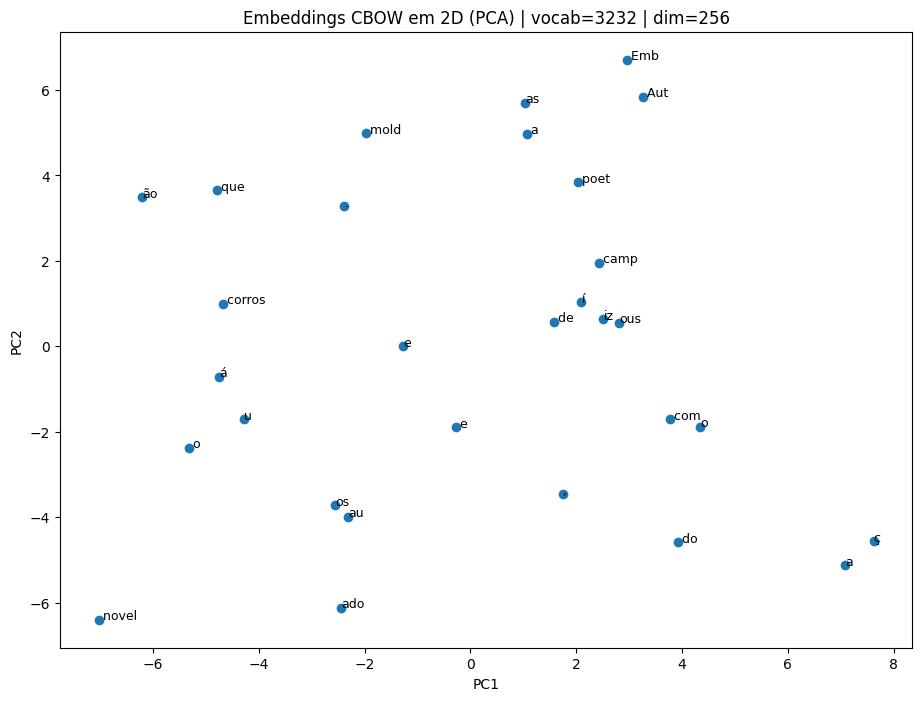

In [7]:
# -------------------------
# 2) Carregar artefatos
# -------------------------
remap_path = pasta_data / "remapeamento_vocab.json"
token_ids_path = pasta_data / "token_ids_compactos.pt"

remap_dict = _carregar_json(remap_path)
token_ids_compactos = torch.load(token_ids_path, map_location="cpu")
if isinstance(token_ids_compactos, torch.Tensor):
    token_ids_compactos = token_ids_compactos.tolist()

W = torch.load(caminho_pesos, map_location="cpu")
if not isinstance(W, torch.Tensor):
    raise TypeError("O arquivo de pesos não é um torch.Tensor.")

vocab_size_compacto = int(W.shape[0])
emb_dim = int(W.shape[1])

# encoding_name (se existir no JSON)
encoding_name = remap_dict.get("encoding_name", "gpt2")

compacto_para_raw = _inferir_compacto_para_raw(remap_dict, vocab_size_compacto=vocab_size_compacto)

# Frequências dos tokens no corpus
freq = Counter(int(x) for x in token_ids_compactos)

# -------------------------
# 3) Escolher tokens p/ mostrar
# -------------------------
N_TOP = 20          # quantos mais frequentes
N_RANDOM = 10       # quantos aleatórios extras
N_PLOT = 35         # quantos no gráfico 2D (total)

top_ids = [tid for tid, _ in freq.most_common(N_TOP)]
rng = np.random.default_rng(42)
all_ids = np.arange(vocab_size_compacto)
rand_ids = rng.choice(all_ids, size=min(N_RANDOM, vocab_size_compacto), replace=False).tolist()

ids_mostrar = list(dict.fromkeys(top_ids + rand_ids))  # unique preservando ordem
ids_plot = ids_mostrar[: min(N_PLOT, len(ids_mostrar))]

# tokens (texto)
if compacto_para_raw is not None:
    raw_ids_mostrar = [compacto_para_raw[i] for i in ids_mostrar]
    tokens_mostrar = _decoder_raw_ids(raw_ids_mostrar, encoding_name=encoding_name)
else:
    raw_ids_mostrar = [None] * len(ids_mostrar)
    tokens_mostrar = [f"<compact_id={i}>" for i in ids_mostrar]

# -------------------------
# 4) Tabela: tokens + embeddings (primeiras dims)
# -------------------------
K = min(8, emb_dim)  # quantas dimensões do vetor mostrar na tabela
rows = []
for i, tok, rid in zip(ids_mostrar, tokens_mostrar, raw_ids_mostrar):
    vec = W[i].detach().cpu().numpy()
    rows.append(
        {
            "compact_id": int(i),
            "raw_id": (int(rid) if rid is not None else None),
            "token": tok,
            "freq_no_corpus": int(freq.get(int(i), 0)),
            **{f"e{j}": float(vec[j]) for j in range(K)},
        }
    )

df = pd.DataFrame(rows).sort_values(["freq_no_corpus", "compact_id"], ascending=[False, True])
display(df.reset_index(drop=True))

# -------------------------
# 5) Gráfico 2D (PCA)
# -------------------------
X = np.stack([W[i].detach().cpu().numpy() for i in ids_plot], axis=0)
coords = _pca_2d(X)

# tokens (plot)
if compacto_para_raw is not None:
    raw_ids_plot = [compacto_para_raw[i] for i in ids_plot]
    tokens_plot = _decoder_raw_ids(raw_ids_plot, encoding_name=encoding_name)
else:
    tokens_plot = [f"{i}" for i in ids_plot]

plt.figure(figsize=(11, 8))
plt.scatter(coords[:, 0], coords[:, 1])

for (x, y), t in zip(coords, tokens_plot):
    # manter rótulos curtos (BPE pode ter tokens enormes)
    label = t.replace("\n", "\\n")
    if len(label) > 18:
        label = label[:18] + "…"
    plt.text(x, y, label, fontsize=9)

plt.title(f"Embeddings CBOW em 2D (PCA) | vocab={vocab_size_compacto} | dim={emb_dim}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()